# Recurrent Neural Networks

## Import modules

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM

## Đọc dữ liệu train, chuyển cột 'Date' sang dạng DateTime

In [3]:
train = pd.read_csv('../data/Google_Stock_Price_Train.csv')
train['Date'] = pd.to_datetime(train['Date'])
train = train.set_index('Date')
train.head()

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,325.25,332.83,324.97,663.59,"7,380,500"
2012-01-04,331.27,333.87,329.08,666.45,"5,749,400"
2012-01-05,329.83,330.75,326.89,657.21,"6,590,300"
2012-01-06,328.34,328.77,323.68,648.24,"5,405,900"
2012-01-09,322.04,322.29,309.46,620.76,"11,688,800"


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2012-01-03 to 2016-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   object 
 4   Volume  1258 non-null   object 
dtypes: float64(3), object(2)
memory usage: 59.0+ KB


In [5]:
train = train.loc[:, ['Close']]
# Xoá bớt dấu , của dữ liệu, ví dụ 1,234.56 => 1234.56 
# (Chỉ có cột 'Close' và 'Volume' bị vấn đề này nên mới có Dtype là object)
train = train.replace(',','', regex=True)
# Ép kiểu sang dạng số thực (đang là object)
train['Close'] = train['Close'].astype('float32')
train.head(20)

,Close
Date,
2012-01-03,663.590027
2012-01-04,666.450012
2012-01-05,657.210022
2012-01-06,648.239990
2012-01-09,620.760010
2012-01-10,621.429993
2012-01-11,624.250000
2012-01-12,627.919983
2012-01-13,623.280029


<AxesSubplot:xlabel='Date'>

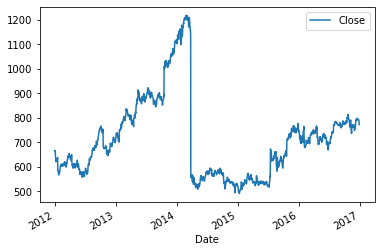

In [6]:
train.plot()

## Đọc dữ liệu test, chuyển cột 'Date' sang dạng DateTime

In [7]:
test = pd.read_csv('../data/Google_Stock_Price_Test.csv')
test['Date'] = pd.to_datetime(test['Date'])
test = test.set_index('Date')
test.head()

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-03,778.81,789.63,775.80,786.14,"1,657,300"
2017-01-04,788.36,791.34,783.16,786.90,"1,073,000"
2017-01-05,786.08,794.48,785.02,794.02,"1,335,200"
2017-01-06,795.26,807.90,792.20,806.15,"1,640,200"
2017-01-09,806.40,809.97,802.83,806.65,"1,272,400"


In [8]:
test = test.loc[:, ['Close']]
test.head()
# test.plot()

,Close
Date,
2017-01-03,786.14
2017-01-04,786.90
2017-01-05,794.02
2017-01-06,806.15
2017-01-09,806.65


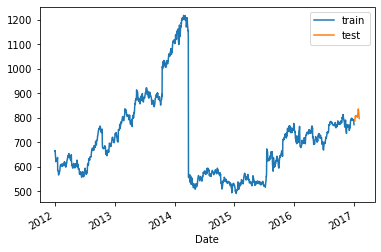

In [9]:
ax = train.plot()
test.plot(ax=ax)
plt.legend(['train', 'test'])

## Scaling

In [10]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [11]:
train_sc[:4]

array([[0.23757291],
       [0.24151427],
       [0.22878051],
       [0.2164188 ]], dtype=float32)

In [12]:
# Lấy y dịch lùi đi một bước thời gian sẽ là X
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]

In [13]:
early_stop = EarlyStopping(monitor='loss', patience=2, verbose=1)

In [14]:
train_sc.shape

(1258, 1)

In [15]:
train_sc_df = pd.DataFrame(train_sc, columns=['Scaled'], index=train.index)
test_sc_df = pd.DataFrame(test_sc, columns=['Scaled'], index=test.index)
train_sc_df.head()

,Scaled
Date,
2012-01-03,0.237573
2012-01-04,0.241514
2012-01-05,0.228781
2012-01-06,0.216419
2012-01-09,0.178548


## Tạo các rolling window có kích thước 5 ngày

In [16]:
window_size = 5 # Chú ý chọn window_size sao cho không để mất dữ liệu test vốn có ít data point
for s in range(1, window_size+1):
    train_sc_df['{} days before'.format(s)] = train_sc_df['Scaled'].shift(s)
    test_sc_df['{} days before'.format(s)] = test_sc_df['Scaled'].shift(s)

In [17]:
train_sc_df.head(window_size)

,Scaled,1 days before,2 days before,3 days before,4 days before,5 days before
Date,,,,,,
2012-01-03,0.237573,NaN,NaN,NaN,NaN,NaN
2012-01-04,0.241514,0.237573,NaN,NaN,NaN,NaN
2012-01-05,0.228781,0.241514,0.237573,NaN,NaN,NaN
2012-01-06,0.216419,0.228781,0.241514,0.237573,NaN,NaN
2012-01-09,0.178548,0.216419,0.228781,0.241514,0.237573,NaN


### Drop 5 dòng đầu

In [18]:
X_train = train_sc_df.dropna().drop('Scaled', axis=1)
y_train = train_sc_df.dropna()[['Scaled']]

X_test = test_sc_df.dropna().drop('Scaled', axis=1)
y_test = test_sc_df.dropna()[['Scaled']]

In [19]:
X_train.head()

,1 days before,2 days before,3 days before,4 days before,5 days before
Date,,,,,
2012-01-10,0.178548,0.216419,0.228781,0.241514,0.237573
2012-01-11,0.179472,0.178548,0.216419,0.228781,0.241514
2012-01-12,0.183358,0.179472,0.178548,0.216419,0.228781
2012-01-13,0.188416,0.183358,0.179472,0.178548,0.216419
2012-01-17,0.182021,0.188416,0.183358,0.179472,0.178548


In [20]:
X_train.shape

(1253, 5)

In [21]:
X_train = X_train.values
X_test= X_test.values

y_train = y_train.values
y_test = y_test.values

In [22]:
X_train_t = X_train.reshape(X_train.shape[0], 1, window_size)
X_test_t = X_test.reshape(X_test.shape[0], 1, window_size)

In [23]:
X_test_t.shape

(15, 1, 5)

### Tạo model RNN

In [24]:
K.clear_session()
model = Sequential()
# Thêm lớp LSTM, thiết lập return_sequences=True để mỗi node ra trả ra một output
model.add(LSTM(20, input_shape=(1, window_size), return_sequences=True))
model.add(LSTM(20))
# Thêm lớp DNN đầu ra
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1))
# Thiết lập thông số
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 20)             2080      
_________________________________________________________________
lstm_1 (LSTM)                (None, 20)                3280      
_________________________________________________________________
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 5,581
Trainable params: 5,581
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.fit(X_train_t, y_train, epochs=100,
          batch_size=3, verbose=1, callbacks=[early_stop])

Epoch 1/100
418/418 [==============================] - 14s 14ms/step - loss: 0.0171
Epoch 2/100
418/418 [==============================] - 6s 14ms/step - loss: 0.0016
Epoch 3/100
418/418 [==============================] - 7s 16ms/step - loss: 0.0015
Epoch 4/100
418/418 [==============================] - 7s 16ms/step - loss: 0.0013
Epoch 5/100
418/418 [==============================] - 7s 17ms/step - loss: 0.0013
Epoch 6/100
418/418 [==============================] - 8s 19ms/step - loss: 0.0013
Epoch 7/100
418/418 [==============================] - 6s 15ms/step - loss: 0.0011
Epoch 8/100
418/418 [==============================] - 6s 15ms/step - loss: 0.0010
Epoch 9/100
418/418 [==============================] - 6s 15ms/step - loss: 0.0011
Epoch 10/100
418/418 [==============================] - 7s 16ms/step - loss: 0.0011
Epoch 00010: early stopping


## Đánh giá

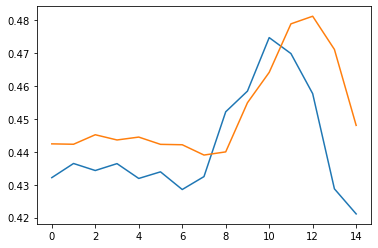

In [26]:
y_pred = model.predict(X_test_t)
plt.plot(y_test)
plt.plot(y_pred)

In [27]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_pred, squared=False)

0.016716823522668234